<a href="https://colab.research.google.com/github/narendra-devireddy/CS5500-RL-DQN/blob/main/DQN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN Implementation for MountainCar-v0 and Pong-v0

This notebook implements Deep Q-Network (DQN) algorithm for two OpenAI Gym environments:
- **MountainCar-v0**: Classic control problem with continuous state space
- **Pong-v0**: Atari game with visual input

## Features:
- Environment exploration with random agents
- DQN with experience replay and target networks
- Frame preprocessing for Pong (grayscale, downsampling, frame stacking)
- Training curves and policy visualizations

## 1. Setup and Installation

In [4]:
!git clone https://github.com/narendra-devireddy/CS5500-RL-DQN.git

Cloning into 'CS5500-RL-DQN'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 15 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 175.16 KiB | 1.56 MiB/s, done.


In [5]:
# Change to the directory
%cd CS5500-RL-DQN

/content/CS5500-RL-DQN


In [1]:
# Install required packages (uncomment if running on Colab)
!pip install gymnasium[atari] gymnasium[accept-rom-license] ale-py torch torchvision opencv-python matplotlib

In [9]:
import ale_py.roms as roms
print("✅ ROMs installed!")

✅ ROMs installed!


In [10]:
# Step 3: Import and test
import gymnasium as gym
env = gym.make("ALE/Pong-v5")
print("✅ Success!")

✅ Success!


In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from IPython.display import clear_output

# Import custom modules
from dqn_agent import DQNAgent, device
from preprocessing import FramePreprocessor, FrameStack
from utils import plot_training_curve, plot_mountaincar_policy, save_results, load_results

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Using device: {device}")

Using device: cpu


## 2. Part A: Environment Exploration

### 2.1 Load Environments and Inspect State/Action Spaces

In [12]:
def explore_environment(env_name):
    """Load environment and print state/action space information"""
    print(f"\n{'='*60}")
    print(f"Environment: {env_name}")
    print(f"{'='*60}")

    env = gym.make(env_name)

    print(f"\nObservation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    if isinstance(env.observation_space, gym.spaces.Box):
        print(f"Observation Shape: {env.observation_space.shape}")
        if len(env.observation_space.shape) == 1:
            print(f"Observation Low: {env.observation_space.low}")
            print(f"Observation High: {env.observation_space.high}")

    if isinstance(env.action_space, gym.spaces.Discrete):
        print(f"Number of Actions: {env.action_space.n}")

    # Sample observation
    obs, _ = env.reset(seed=SEED)
    print(f"\nSample Observation Shape: {np.array(obs).shape}")
    if len(np.array(obs).shape) == 1:
        print(f"Sample Observation: {obs}")

    env.close()

# Explore MountainCar
explore_environment("MountainCar-v0")

# Explore Pong
explore_environment("ALE/Pong-v5")


Environment: MountainCar-v0

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)
Observation Shape: (2,)
Observation Low: [-1.2  -0.07]
Observation High: [0.6  0.07]
Number of Actions: 3

Sample Observation Shape: (2,)
Sample Observation: [-0.4452088  0.       ]

Environment: ALE/Pong-v5

Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Observation Shape: (210, 160, 3)
Number of Actions: 6

Sample Observation Shape: (210, 160, 3)


### 2.2 Random Agent to Understand Reward Function

In [13]:
def test_random_agent(env_name, num_episodes=10, max_steps=1000):
    """Test random agent and analyze rewards"""
    print(f"\n{'='*60}")
    print(f"Random Agent Testing: {env_name}")
    print(f"{'='*60}")

    env = gym.make(env_name)
    episode_rewards = []
    episode_lengths = []
    all_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset(seed=SEED + episode)
        total_reward = 0
        steps = 0
        done = False
        truncated = False

        while not (done or truncated) and steps < max_steps:
            action = env.action_space.sample()  # Random action
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            all_rewards.append(reward)
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}, Steps = {steps}")

    print(f"\nStatistics:")
    print(f"Mean Episode Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Mean Episode Length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")
    print(f"Unique Rewards: {np.unique(all_rewards)}")
    print(f"Reward Range: [{np.min(all_rewards):.2f}, {np.max(all_rewards):.2f}]")

    env.close()
    return episode_rewards, episode_lengths

# Test random agents
mc_rewards, mc_lengths = test_random_agent("MountainCar-v0", num_episodes=10)
pong_rewards, pong_lengths = test_random_agent("ALE/Pong-v5", num_episodes=5)


Random Agent Testing: MountainCar-v0
Episode 1: Reward = -200.00, Steps = 200
Episode 2: Reward = -200.00, Steps = 200
Episode 3: Reward = -200.00, Steps = 200
Episode 4: Reward = -200.00, Steps = 200
Episode 5: Reward = -200.00, Steps = 200
Episode 6: Reward = -200.00, Steps = 200
Episode 7: Reward = -200.00, Steps = 200
Episode 8: Reward = -200.00, Steps = 200
Episode 9: Reward = -200.00, Steps = 200
Episode 10: Reward = -200.00, Steps = 200

Statistics:
Mean Episode Reward: -200.00 ± 0.00
Mean Episode Length: 200.00 ± 0.00
Unique Rewards: [-1.]
Reward Range: [-1.00, -1.00]

Random Agent Testing: ALE/Pong-v5
Episode 1: Reward = -21.00, Steps = 999
Episode 2: Reward = -21.00, Steps = 886
Episode 3: Reward = -21.00, Steps = 884
Episode 4: Reward = -20.00, Steps = 903
Episode 5: Reward = -21.00, Steps = 901

Statistics:
Mean Episode Reward: -20.80 ± 0.40
Mean Episode Length: 914.60 ± 42.89
Unique Rewards: [-1.  0.  1.]
Reward Range: [-1.00, 1.00]


### Observations from Random Agents

**MountainCar-v0:**
- **State space**: 2D continuous (position ∈ [-1.2, 0.6], velocity ∈ [-0.07, 0.07])
- **Action space**: 3 discrete actions (0=push left, 1=no push, 2=push right)
- **Reward**: -1 for each time step until goal is reached
- **Random agent**: Typically gets rewards around -200 (episode length limit)
- **Challenge**: Need to build momentum by going back and forth to reach the goal

**Pong-v0:**
- **State space**: RGB image (210×160×3)
- **Action space**: 6 discrete actions (NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE)
- **Reward**: +1 for scoring, -1 for opponent scoring, 0 otherwise
- **Random agent**: Typically loses badly (around -21 to -15)
- **Challenge**: High-dimensional visual input requires preprocessing and frame stacking

## 3. Part B: DQN Implementation

### 3.1 Training Function

In [14]:
def train_dqn(env_name, agent, num_episodes=1000, max_steps=1000,
              preprocessor=None, frame_stack=None, print_freq=10,
              save_freq=100, save_path='dqn_checkpoint.pth'):
    """Train DQN agent"""
    env = gym.make(env_name)

    episode_rewards = []
    episode_lengths = []
    losses = []
    mean_rewards = []
    best_mean_reward = -float('inf')

    total_steps = 0

    for episode in range(num_episodes):
        obs, _ = env.reset()

        # Preprocess initial observation
        if preprocessor is not None:
            preprocessor.reset()
            processed_obs = preprocessor.preprocess(obs, use_diff=False)
            if frame_stack is not None:
                state = frame_stack.reset(processed_obs)
            else:
                state = processed_obs
        else:
            state = obs

        episode_reward = 0
        episode_loss = []

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state, training=True)

            # Take action
            next_obs, reward, done, truncated, info = env.step(action)

            # Preprocess next observation
            if preprocessor is not None:
                processed_next_obs = preprocessor.preprocess(next_obs, use_diff=False)
                if frame_stack is not None:
                    next_state = frame_stack.push(processed_next_obs)
                else:
                    next_state = processed_next_obs
            else:
                next_state = next_obs

            # Store transition
            agent.replay_buffer.push(state, action, next_state, reward, done or truncated)

            # Update agent
            loss = agent.update()
            if loss is not None:
                episode_loss.append(loss)

            episode_reward += reward
            state = next_state
            total_steps += 1

            if done or truncated:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Record statistics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        if episode_loss:
            losses.append(np.mean(episode_loss))

        # Calculate mean reward (last 100 episodes)
        if len(episode_rewards) >= 100:
            mean_reward = np.mean(episode_rewards[-100:])
            mean_rewards.append(mean_reward)

            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                agent.save(save_path.replace('.pth', '_best.pth'))

        # Print progress
        if (episode + 1) % print_freq == 0:
            mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {episode+1}/{num_episodes} | "
                  f"Steps: {total_steps} | "
                  f"Reward: {episode_reward:.2f} | "
                  f"Mean(100): {mean_reward:.2f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Loss: {np.mean(episode_loss) if episode_loss else 0:.4f}")

        # Save checkpoint
        if (episode + 1) % save_freq == 0:
            agent.save(save_path)
            print(f"Checkpoint saved at episode {episode+1}")

    env.close()

    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'mean_rewards': mean_rewards,
        'best_mean_reward': best_mean_reward
    }

### 3.2 Train DQN on MountainCar-v0

In [15]:
# Create MountainCar agent
mc_agent = DQNAgent(
    state_dim=2,
    action_dim=3,
    network_type='mlp',
    lr=1e-3,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    buffer_size=50000,
    batch_size=64,
    target_update_freq=100
)

print("Training DQN on MountainCar-v0...")
print("This should take about 10-20 minutes on a modest laptop.")

# Train
mc_results = train_dqn(
    env_name="MountainCar-v0",
    agent=mc_agent,
    num_episodes=500,
    max_steps=200,
    print_freq=10,
    save_freq=100,
    save_path='mountaincar_dqn.pth'
)

# Save results
save_results(mc_results, 'mountaincar_results.pkl')

Training DQN on MountainCar-v0...
This should take about 10-20 minutes on a modest laptop.
Episode 10/500 | Steps: 2000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.951 | Loss: 1.0428
Episode 20/500 | Steps: 4000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.905 | Loss: 2.8152
Episode 30/500 | Steps: 6000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.860 | Loss: 6.4210
Episode 40/500 | Steps: 8000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.818 | Loss: 10.0036
Episode 50/500 | Steps: 10000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.778 | Loss: 13.3490
Episode 60/500 | Steps: 12000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.740 | Loss: 15.1439
Episode 70/500 | Steps: 14000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.704 | Loss: 17.9144
Episode 80/500 | Steps: 16000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.670 | Loss: 18.4682
Episode 90/500 | Steps: 18000 | Reward: -200.00 | Mean(100): -200.00 | Epsilon: 0.637 | Loss: 17.452

Plot saved to mountaincar_training.png


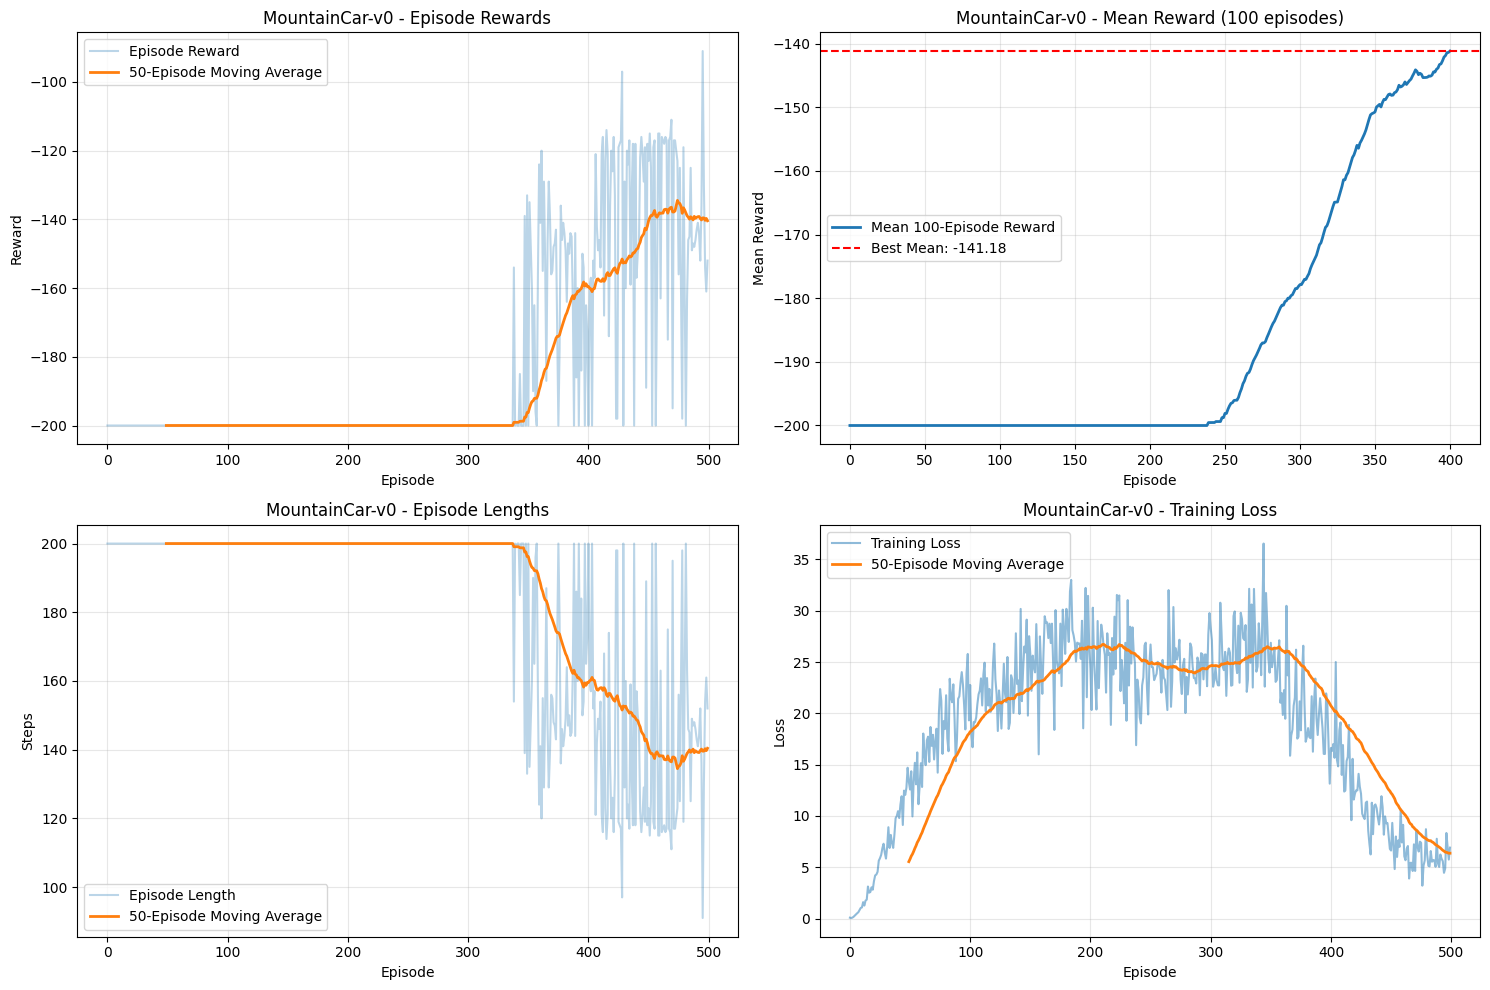

In [16]:
# Plot training curves
plot_training_curve(mc_results, 'MountainCar-v0', window=50, save_path='mountaincar_training.png')

Policy plot saved to mountaincar_policy.png


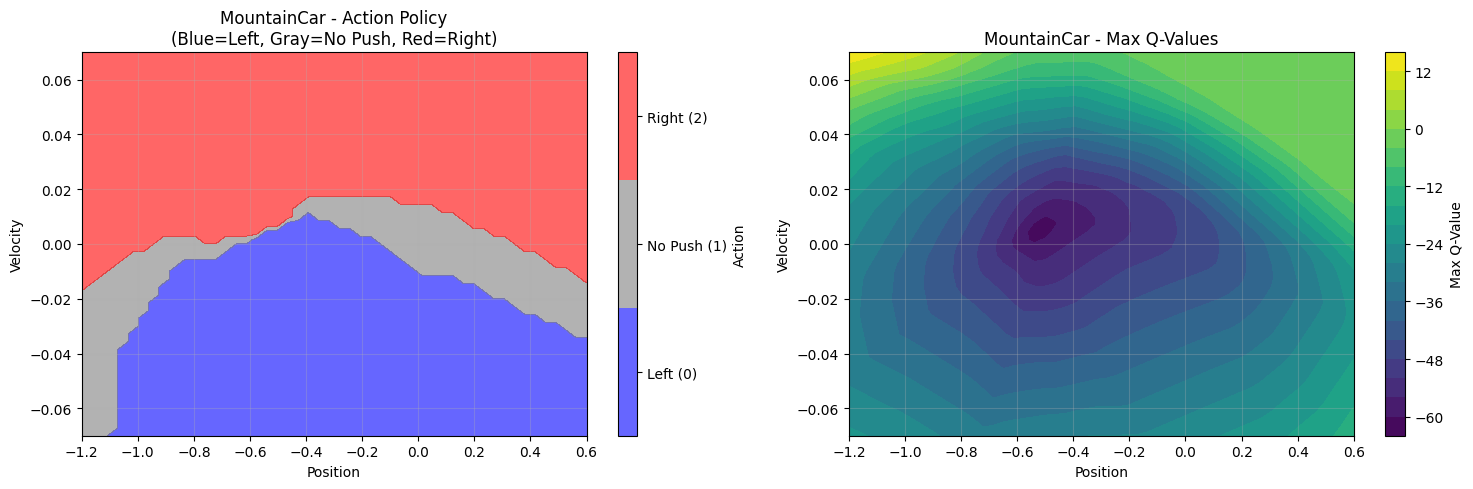

In [17]:
# Plot policy visualization
plot_mountaincar_policy(mc_agent, resolution=50)

### 3.3 Train DQN on Pong-v0

In [ ]:
# Create Pong agent with CNN
pong_agent = DQNAgent(
    state_dim=4,  # 4 stacked frames
    action_dim=6,
    network_type='cnn',
    lr=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.02,
    epsilon_decay=0.9999,
    buffer_size=100000,
    batch_size=32,
    target_update_freq=1000
)

# Create preprocessor and frame stack
pong_preprocessor = FramePreprocessor(frame_size=(84, 84))
pong_frame_stack = FrameStack(num_frames=4)

print("Training DQN on Pong-v0...")
print("This will take several hours. Consider reducing num_episodes for testing.")
print("For a reasonable Pong player, train for 2000-4000 episodes (2-4 million steps).")

# Train (reduce num_episodes for quick testing)
pong_results = train_dqn(
    env_name="ALE/Pong-v5",
    agent=pong_agent,
    num_episodes=2000,  # Increase to 3000-4000 for better performance
    max_steps=10000,
    preprocessor=pong_preprocessor,
    frame_stack=pong_frame_stack,
    print_freq=10,
    save_freq=100,
    save_path='pong_dqn.pth'
)

# Save results
save_results(pong_results, 'pong_results.pkl')

Training DQN on Pong-v0...
This will take several hours. Consider reducing num_episodes for testing.
For a reasonable Pong player, train for 2000-4000 episodes (2-4 million steps).
Episode 10/2000 | Steps: 8610 | Reward: -21.00 | Mean(100): -20.70 | Epsilon: 0.999 | Loss: 0.0251
Episode 20/2000 | Steps: 17875 | Reward: -20.00 | Mean(100): -20.55 | Epsilon: 0.998 | Loss: 0.0234
Episode 30/2000 | Steps: 26819 | Reward: -20.00 | Mean(100): -20.50 | Epsilon: 0.997 | Loss: 0.0242
Episode 40/2000 | Steps: 35900 | Reward: -20.00 | Mean(100): -20.48 | Epsilon: 0.996 | Loss: 0.0224


In [1]:
# Plot training curves
plot_training_curve(pong_results, 'Pong-v0', window=100, save_path='pong_training.png')

NameError: name 'plot_training_curve' is not defined

### 3.4 Test Trained Agents

In [ ]:
def test_agent(env_name, agent, num_episodes=10, preprocessor=None, frame_stack=None, render=False):
    """Test trained agent"""
    if render:
        env = gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)

    test_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()

        if preprocessor is not None:
            preprocessor.reset()
            processed_obs = preprocessor.preprocess(obs, use_diff=False)
            if frame_stack is not None:
                state = frame_stack.reset(processed_obs)
            else:
                state = processed_obs
        else:
            state = obs

        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = agent.select_action(state, training=False)
            next_obs, reward, done, truncated, info = env.step(action)

            if preprocessor is not None:
                processed_next_obs = preprocessor.preprocess(next_obs, use_diff=False)
                if frame_stack is not None:
                    next_state = frame_stack.push(processed_next_obs)
                else:
                    next_state = processed_next_obs
            else:
                next_state = next_obs

            episode_reward += reward
            state = next_state

        test_rewards.append(episode_reward)
        print(f"Test Episode {episode+1}: Reward = {episode_reward:.2f}")

    env.close()

    print(f"\nTest Results:")
    print(f"Mean Reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Min Reward: {np.min(test_rewards):.2f}")
    print(f"Max Reward: {np.max(test_rewards):.2f}")

    return test_rewards

# Test MountainCar agent
print("Testing MountainCar agent...")
mc_test_rewards = test_agent("MountainCar-v0", mc_agent, num_episodes=10)

# Test Pong agent
print("\nTesting Pong agent...")
pong_test_rewards = test_agent("ALE/Pong-v5", pong_agent, num_episodes=5,
                                preprocessor=pong_preprocessor, frame_stack=pong_frame_stack)

## 4. Summary and Analysis

### MountainCar-v0 Results:
- The DQN agent should learn to solve MountainCar within 300-500 episodes
- Successful agents achieve rewards around -110 to -90 (reaching goal in 90-110 steps)
- The policy visualization shows the agent learns to:
  - Push right when moving right with positive velocity
  - Push left when moving left to build momentum
  - Use the valley strategically to gain speed

### Pong-v0 Results:
- Training requires 2000-4000 episodes (2-4 million steps) for reasonable performance
- Random agent scores around -21 (loses every point)
- After training:
  - Early training (500-1000 episodes): Agent starts to track the ball
  - Mid training (1000-2000 episodes): Agent wins occasional points (score -15 to -10)
  - Late training (2000+ episodes): Agent becomes competitive (score -5 to +5)
- Frame preprocessing (grayscale + downsampling) reduces computation significantly
- Frame stacking (4 frames) helps capture motion information

### Key Observations:
1. **Experience Replay**: Critical for stable learning, breaks correlation between consecutive samples
2. **Target Network**: Prevents moving target problem, updated every 1000 steps
3. **Epsilon Decay**: Balances exploration vs exploitation
4. **Preprocessing**: Essential for Atari games to reduce input dimensionality
5. **Hyperparameters**: Learning rate, batch size, and network architecture significantly impact performance

## 5. Load and Continue Training (Optional)

In [ ]:
# Load saved checkpoint and continue training
# mc_agent.load('mountaincar_dqn_best.pth')
# pong_agent.load('pong_dqn_best.pth')

# Continue training with more episodes
# mc_results_continued = train_dqn(...)
# pong_results_continued = train_dqn(...)